# Implementation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import random
import math

## Tree Model

In [ ]:
class Node:
  """A Node"""

  ops = ('+', '-', '*', '/')

  def __init__(self, value, children=None):
    self.parent = None
    # Default children to a new list
    if children is None: children = []
    # If the value is already a node use its values
    if type(value) == Node:
      self.children = value.copy().children
      self.value = value.value
    else:
      self.value = value
      self.children = children

  #
  # Children
  #

  @property
  def children(self):
    return self._children

  @children.setter
  def children(self, children):
    """Setting a child also sets the parent of the child"""
    for child in children:
      child.parent = self
    self._children = children

  def __len__(self):
    return len(self.children)

  def __getitem__(self, i):
    return self.children[i]

  def __setitem__(self, i, value):
    self.children[i] = value

  def __iter__(self):
    yield from self.children

  def nodes(self, node_list=None):
    """Returns a list of all nodes"""
    if node_list is None: node_list = []
    node_list.append(self)
    for child in self:
      child.nodes(node_list)
    return node_list

  def depth(self):
    return max([1] + [1 + child.depth() for child in self.children])

  def root(self):
    """Returns the root of the tree"""
    if self.parent is None:
      return self
    else:
      return self.parent.root()

  def replace(self, new_node):
    """Replaces this node and all children with a new branch"""
    # Create a copy of the new node
    new_node = new_node.copy()
    # Return the new node if self is the root of the tree
    if self.parent is None: return new_node
    # Parent's index for self
    parent_index = self.parent.children.index(self)
    # Replace the parent's reference to self
    self.parent[parent_index] = new_node
    # Replace the new Node's reference to parent
    new_node.parent = self.parent
    # Remove self reference to parent
    self.parent = None
    # Return the full new tree
    return new_node.root()

  #
  # Evaluation and native Python operations
  #

  @staticmethod
  def op(operation, *operands):
    """Return a new Node from an operation on other Nodes"""
    # Convert operands to a list to be modified
    operands = list(operands)
    # Cast each operand to a Node or copy it if it is already a Node
    for i in range(len(operands)):
      if type(operands[i]) != Node:
        operands[i] = Node(operands[i])
      else:
        operands[i] = operands[i].copy()
    # Return a new Node with the operands as the children
    return Node(operation, operands)

  def      __add__(self, other): return Node.op('+',  self, other)
  def      __sub__(self, other): return Node.op('-',  self, other)
  def      __mul__(self, other): return Node.op('*',  self, other)
  def  __truediv__(self, other): return Node.op('/',  self, other)
  def      __pow__(self, other): return Node.op('**', self, other)
  def     __radd__(self, other): return Node.op('+',  other, self)
  def     __rsub__(self, other): return Node.op('-',  other, self)
  def     __rmul__(self, other): return Node.op('*',  other, self)
  def __rtruediv__(self, other): return Node.op('/',  other, self)
  def     __rpow__(self, other): return Node.op('**', other, self)

  def __call__(self, x, algebraic=False):
    """Calling evaluates the value of the entire tree"""

    # Simplify algebraicaly before evaluation
    if algebraic:
      # The Node's value is not a string, return it
      if type(self.value) != str:
        return sp.Number(self.value)
      # The Node's value is a variable, return  of x
      if self.value == 'x':
        return sp.Symbol('x')
      # The node has children, recursivly evaluate them
      match self.value:
        case '+':  f = self[0](None, algebraic) +  self[1](None, algebraic)
        case '-':  f = self[0](None, algebraic) -  self[1](None, algebraic)
        case '*':  f = self[0](None, algebraic) *  self[1](None, algebraic)
        case '**': f = self[0](None, algebraic) ** self[1](None, algebraic)
        case '/':
          # Return 1 if dividing by zero
          if self[1](None, algebraic) == 0:
            f = sp.Number(1)
          else:

            f = self[0](None, algebraic) / self[1](None, algebraic)
      if x is None:
        return f
      else:
        return f.evalf(subs={'x': x})

    # Evaluate as is
    else:
      if type(self.value) != str:
        return self.value
      # The Node's value is a variable, return the value of x
      elif self.value == 'x':
        return x
      # The node has children, recursivly evaluate them
      match self.value:
        case '+':  return self[0](x, algebraic) +  self[1](x, algebraic)
        case '-':  return self[0](x, algebraic) -  self[1](x, algebraic)
        case '*':  return self[0](x, algebraic) *  self[1](x, algebraic)
        case '**': return self[0](x, algebraic) ** self[1](x, algebraic)
        case '/':
          if self[1](x, algebraic) == 0:
            return 1
          else:
            # print('HERE', self[0](x, algebraic))
            return self[0](x, algebraic) / self[1](x, algebraic)

  #
  # Strings
  #

  def __str__(self):
    if len(self) == 2:
      return f'({self[0]} {self.value} {self[1]})'
    else:
      return str(self.value)

  def __repr__(self):
    """String representation"""
    return str(self)

  #
  # Utils
  #

  def copy(self):
    """Returns a recursive deepcopy of all Nodes"""
    return Node(self.value, [child.copy() for child in self])

## Initialization

In [ ]:
def gen_chromosome(tree_depth, p_branch=.5, leaves=['x'], init_call=True, **kwargs):
  """Generate a random chromosome"""
  # Create a branch with an operator value
  if init_call or random.random() < p_branch and tree_depth > 0:
    # Pick operation
    op = random.choice(Node.ops)
    # Generate children
    c0 = gen_chromosome(tree_depth-1, p_branch, leaves, False)
    c1 = gen_chromosome(tree_depth-1, p_branch, leaves, False)
    # Return new Node
    return Node(op, [c0, c1])
  # Create a leaf
  else:
    return Node(random.choice(leaves))

# Test
tree_depth = 3
print(gen_chromosome(tree_depth))

((x / (x * x)) * (x - x))


In [ ]:
def gen_pop(M, **kwargs):
  """Generate a random population"""
  return [gen_chromosome(**kwargs) for _ in range(M)]

# Test
pop = gen_pop(3, tree_depth=tree_depth)
print(pop)

[(((x - x) + x) / (x - (x + x))), (((x / x) * x) / x), (x + (x + (x * x)))]


## Evaluation

In [ ]:
def function(x):
  """The objective function"""
  return x ** 5 - 2 * x ** 3 + x

In [ ]:
# xs = np.linspace(-1, 1, 20)

# xs = np.linspace(-1, 1, 21)

# xs = np.arange(-10,10) / 10

# y_true = function(xs)

def fitness(pop, **kwargs):
  """Calculate the fitness value of all chromosomes in a population"""

  xs = np.linspace(*kwargs['x_linspace'])

  y_true = function(xs)

  fits = []

  for node in pop:

    y_node = [node(x, kwargs['algebraic']) for x in xs]

    # fit = (sum((abs(y_true - y_node)) ** 2) / len(xs)) ** (1/2)

    fit = sum(abs(y_true - y_node))

    fits.append(fit)

  return fits

# Test
x = Node('x')
pop = []
# pop.append(  )
pop.append( 0 / x )
pop.append( 0.3 * x )
pop.append( x ** 5 - 2 * x ** 3 + x )
fits = fitness(pop, x_linspace=(-1,1,21), algebraic=not False)
print(fits)

# x = Node('x')
# zero = Node(0)
# n = ((1+3)/((x*((x/x)+3))/(((((x+((x*x)/((zero+3)/((((zero+3)-(((3/(((((zero/((((zero+3)-(zero/x))-zero)+((zero/(zero+3))/((4+((zero+3)-(zero/x)))-1))))-3)+3)-zero)+((zero/(zero+3))/((4+((zero+3)-(zero/x)))-1))))+5)+3))+(zero/((-5+((zero+3)-(zero/(zero/((4+3)/zero)))))-1)))/(zero/(zero/(((-5+5)+3)/(-5*5))))))))+(1+3))-1)+(3*(x+((zero/(x/((((4/(-5/x))-x)+(((zero/(5-zero))/(zero/((((zero/(-5/x))-3)+3)/zero)))-(((x+-4)+(1+3))+5)))/zero)))-(((((zero/(2/x))+5)+3)/((((zero+(1+3))-1)+(3*(x+((zero/(x/((((zero/(-5/x))-x)+(((zero/(-5/x))/(zero/((((zero/(-5/x))+5)+5)/zero)))-(((x+-4)+(1+3))+5)))/zero)))-(((((x/(2/x))+5)+3)/(-5*5))-((zero/(1/(x/zero)))-((zero/x)+5)))))))*5))-((zero/(zero/(x/zero)))-((zero/x)+5)))))))/(((zero-3)+x)/(zero/(zero/((((zero/(2/((-5+((zero+3)-((3*-3)/((zero/(((5-zero)+(zero/((((zero/(2/x))+5)+3)/(-5*-4))))/(zero/((zero+3)-(zero/x)))))+5))))-1)))+5)+3)/(zero*5))))))))
# compare([n], x_linspace=(-1,1,21))
# fitness([n], x_linspace=(-1,1,21), algebraic=False)

[3.31650000000000, 2.82354000000000, 4.78783679369599e-16]


## Mutation

In [ ]:
def subtree_mutation(x, p_m, **kwargs):
  """Preform a mutation with a probability of p_m"""

  # Create a copy of x
  x = x.copy()

  # List of all nodes
  x_nodes = x.nodes()

  # List of all nodes with no children
  x_nodes = [xn for xn in x.nodes() if len(xn) == 0]

  node = random.choice(x_nodes)

  # Probability of mutation
  if (random.random() < p_m):

    if kwargs['verbose'] > 1:
      old_x = x.copy()

    new_branch = gen_chromosome(**kwargs)
    new_x = node.replace(new_branch)

    if kwargs['verbose'] > 1:
      print(f'Mutation: {old_x} replaces {node} with {new_branch} returns {new_x}')

    x = new_x

  return x

# Test
print(subtree_mutation(pop[0], p_m=0, tree_depth=3, verbose=2))
print(subtree_mutation(pop[0], p_m=1, tree_depth=3, verbose=2))

(0 / x)
Mutation: (0 / x) replaces 0 with ((x * (x + x)) / (x * (x - x))) returns (((x * (x + x)) / (x * (x - x))) / x)
(((x * (x + x)) / (x * (x - x))) / x)


## Reproduction

In [ ]:
def select_parent(pop, fits, k, **kwargs):
  """Select a single parent from a tournament of k"""

  # Select the random tournament
  tourn = random.choices(pop, k=k)

  # Created a zipped list of fitness and chromosomes
  parent = [(fits[i], i) for i in range(len(tourn))]

  # Sort all parents by fitness
  parent = sorted(parent)

  # Get the chromosome of the first element
  parent = tourn[parent[0][1]]

  return parent

# Test
print(pop)
print(fits)
print(select_parent(pop, fits, 3))

[(0 / x), (0.3 * x), (((x ** 5) - (2 * (x ** 3))) + x)]
[3.31650000000000, 2.82354000000000, 4.78783679369599e-16]
(0 / x)


In [ ]:
def crossover(a, b, **kwargs):

  # Copy original trees
  a_new = a.copy()
  b_new = b.copy()

  # List of all nodes with children
  a_parent_nodes = [an for an in a_new.nodes() if len(an) > 0]
  b_parent_nodes = [bn for bn in b_new.nodes() if len(bn) > 0]

  # Select a random node with children
  a_parent_node = random.choice(a_parent_nodes)
  b_parent_node = random.choice(b_parent_nodes)

  # Select a random child index
  a_child_node_index = random.randint(0, len(a_parent_node)-1)
  b_child_node_index = random.randint(0, len(b_parent_node)-1)

  # Copy the child
  a_child_node_copy = a_parent_node[a_child_node_index].copy()
  b_child_node_copy = b_parent_node[b_child_node_index].copy()

  # Assign the new children to the opposite parent nodes
  a_parent_node[a_child_node_index] = a_child_node_copy
  b_parent_node[b_child_node_index] = b_child_node_copy

  if kwargs['verbose'] > 1:
    print(f'Crossover: {a}  &  {b}  ->  {a_new}  &  {b_new}')

  return a_new, b_new

# Test
print(crossover(pop[0], pop[1], verbose=1))

((0 / x), (0.3 * x))


## Simulation and Iteration

In [ ]:
def next_pop(**kwargs):
  """Generate the next population"""

  new_pop = []

  # Add the fitness values to the kwargs to pass to other functions
  kwargs['fits'] = fitness(**kwargs)

  # Repeat until the new population is the same size as the old
  while len(new_pop) < len(kwargs['pop']):

    # Select two parents
    c0 = select_parent(**kwargs)
    c1 = select_parent(**kwargs)

    # Crossover
    if (random.random() < kwargs['p_c']):
      # Call the provided crossover function
      c0, c1 = kwargs['crossover_func'](c0, c1, **kwargs)

    # Mutate children
    c0 = kwargs['mutate_func'](c0, **kwargs)
    c1 = kwargs['mutate_func'](c1, **kwargs)

    new_pop.append(c0)
    new_pop.append(c1)

  return new_pop, kwargs['fits']

In [ ]:
def run_sim(**kwargs):

  # Set random seed
  if ('seed' in kwargs):
    random.seed(kwargs['seed'])
    np.random.seed(kwargs['seed'])

  # Initial population
  pop = gen_pop(**kwargs)

  # Initial history
  pop_history = [pop]

  # Initial fitness values
  fit_history = []

  for generation in range(kwargs['T_max']):

    if kwargs['verbose'] > 0:
      print(f'Generation {generation} of {kwargs["T_max"]}')

    # Next generation
    pop, fit = next_pop(pop=pop, **kwargs)

    # Save previous fitnesses
    fit_history.append(fit)

    # Save new population
    pop_history.append(pop)

  # Final fitness values
  fit_history.append(fitness(pop_history[-1], **kwargs))

  if kwargs['verbose'] > 0:
    print('Timeout reached')

  return pop_history, fit_history

## Plotting and Utils

In [ ]:
def disp(histories, f, **kwargs):
  """Display the history"""

  fig, ax = plt.subplots()

  f = np.array(f)
  x = np.array([range(f.shape[1])]).T

  # x = np.repeat(x, f.shape[0], axis=0)

  # Combined average of all results and trials
  # true_avg_y = np.mean(f, axis=(0,2))
  # plt.plot(x, true_avg_y)

  # Largest and smallest values of all results and trials
  # true_max_y = np.min(f, axis=(0,2))
  # true_min_y = np.max(f, axis=(0,2))
  # ax.fill_between(x, true_min_y, true_max_y, alpha=.5, linewidth=0)

  for i in range(f.shape[0]):

    plt.plot(x, np.mean(f[i], axis=1), label=labels[i])

    # Scatter plot all points
    xx = x.repeat(f.shape[2], axis=1).ravel()
    yy = f[i].ravel()
    plt.scatter(xx, yy, 0.1)

  plt.title(kwargs['title'])
  ax.set_yscale('log')
  plt.xlabel('Generation')
  plt.ylabel('Average Fitness Value')
  plt.legend(title=kwargs['label_title'])
  plt.show()

# disp(all_pops, all_fits, labels, 'Types of Leaves', **kwargs)

In [ ]:
def compare(nodes, title=None, label_title=None, labels=None, **kwargs):
  x = np.linspace(*kwargs['x_linspace'])

  label = f'${str(function(sp.Symbol("x"))).replace("**","^")}$'
  plt.scatter(x, function(x), label=label)
  plt.plot(x, function(x))

  for i,node in enumerate(nodes):

    if labels is None:
      label = f'${str(node(sp.Symbol("x"))).replace("**","^")}$'
    else:
      label = f'\"{labels[i]}\", Fitness = {fitness([node], **kwargs)[0]:.3f}'

    plt.scatter(x, [node(i, algebraic=False) for i in x], label=label)
    plt.plot(x, [node(i, algebraic=False) for i in x])

  plt.title(title)
  plt.legend(title=label_title)
  plt.show()

In [ ]:
def best(all_pops, all_fits, run=None, gen=slice(None), **kwargs):

  if run is None:
    runs = range(all_pops.shape[0])
  elif type(run) is not list:
    runs = [run]
  else:
    runs = run

  nodes = []

  # Iterate over all runs
  for run in runs:
    i = all_fits[run,gen,:].argmin()
    node = all_pops[run,gen,:].flatten()[i]
    fit = all_fits[run,gen,:].flatten()[i]
    nodes.append(node)

    # print(np.unravel_index(i, all_fits[run,gen,:].shape))

  compare(nodes, **kwargs)

In [ ]:
def sim(label_title, key, labels, values):
  # All values of all chromosomes of all generations of all runs
  # This can be saved as a 4D array for easy manipulation and access
  all_pops = []
  all_fits = []

  for value in values:
    kwargs[key] = value
    # Append all values of all chromosomes of all generations
    pops, fits = run_sim(**kwargs)
    all_pops.append(pops)
    all_fits.append(fits)

  # Convert to NumPy arrays
  all_fits = np.array(all_fits)
  all_pops_new = np.empty(all_fits.shape, dtype=object)
  all_pops_new[:] = all_pops
  all_pops = all_pops_new

  # Display the current histories
  disp(all_pops, all_fits, title='', labels=labels, label_title=label_title, **kwargs)
  # Best result
  best(all_pops, all_fits, title='Best Overall', label_title=label_title, labels=labels, **kwargs)
  # Best result in last generation
  best(all_pops, all_fits, gen=-1, title='Best of Last Generation', label_title=label_title, labels=labels, **kwargs)

  return all_pops, all_fits

# Experimentation and Analysis

In [ ]:
#@title Default kwargs
kwargs = {
  # The random seed to use for random and Numpy.random
  'seed': 1,

  # Initial max depth of a tree
  'tree_depth': 4,

  # Population size
  'M': 100,

  # Number of randomly chosen parents for each tournanet
  'k': 2,

  # Probability of crossover
  'p_c': 0.25,

  # Function used to create next generation
  'crossover_func': crossover,

  # Probability of a bit mutating
  'p_m': 0.1,

  # Function used to create next generation
  'mutate_func': subtree_mutation,

  # Generations before timeout
  'T_max': 100,

  # Print changes and updates
  'verbose': 0,

  # Simplify algebraicly before evaluating
  'algebraic': False,

  # The domain of the problem expressed using np.linspace
  'x_linspace': (-1,1,20),

  # The valid leaves of the tree
  'leaves': ['x'],
}

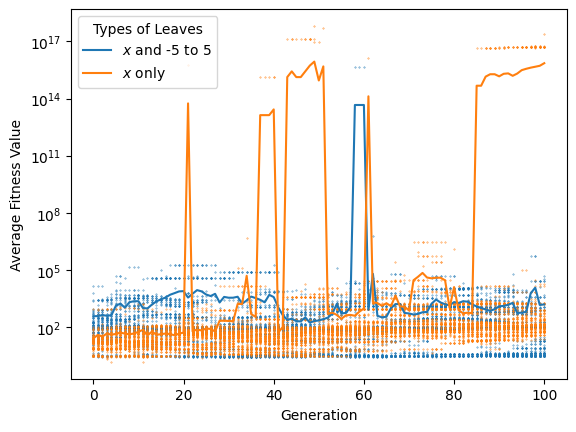

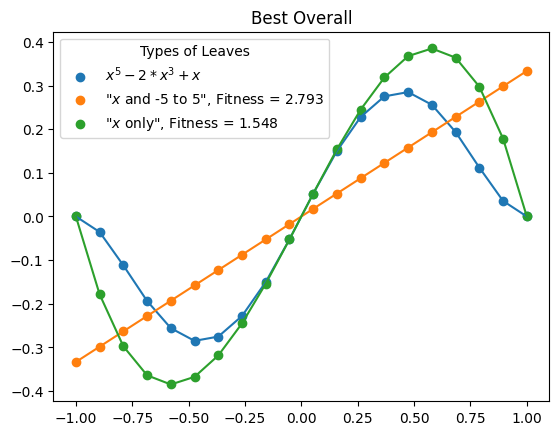

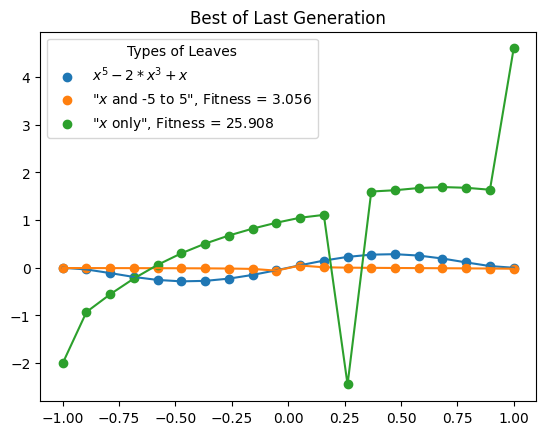

In [ ]:
#@title Types of Leaves
label_title = 'Types of Leaves'
key = 'leaves'
labels = ['$x$ and -5 to 5', '$x$ only']
values = [['x',-5,-4,-3,-2,-1,0,1,2,3,4,5], ['x']]

# Run simulation
all_pops, all_fits = sim(label_title, key, labels, values)

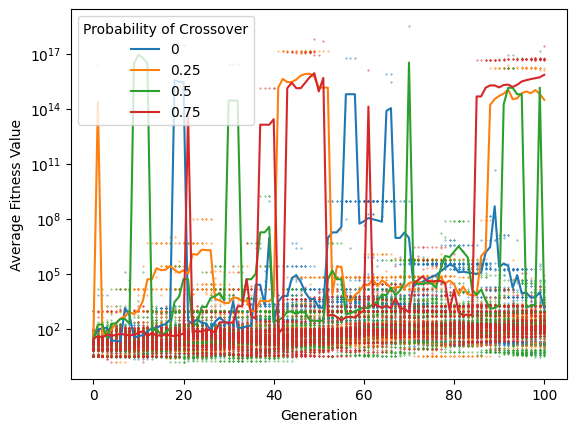

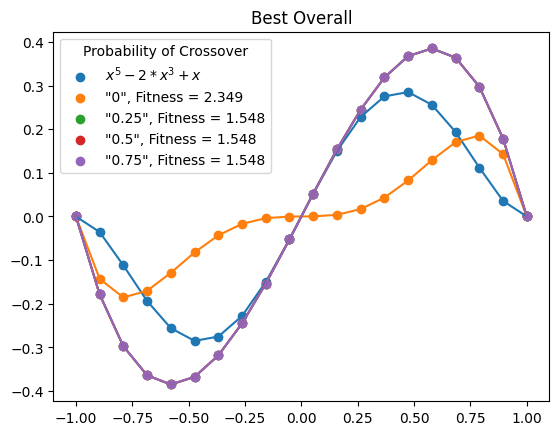

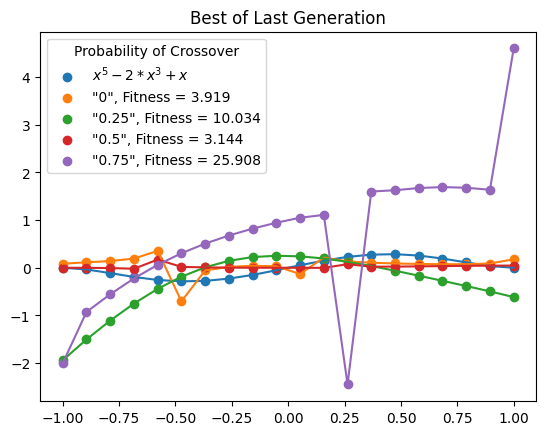

In [ ]:
#@title Probability of Crossover
label_title = 'Probability of Crossover'
key = 'p_c'
labels = values = (0, 0.25, 0.5, 0.75)

# Run simulation
all_pops, all_fits = sim(label_title, key, labels, values)

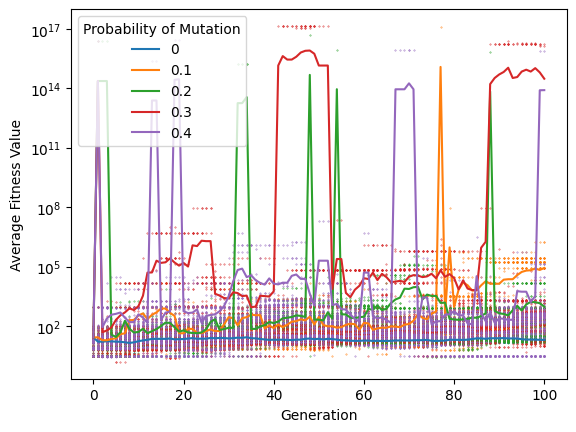

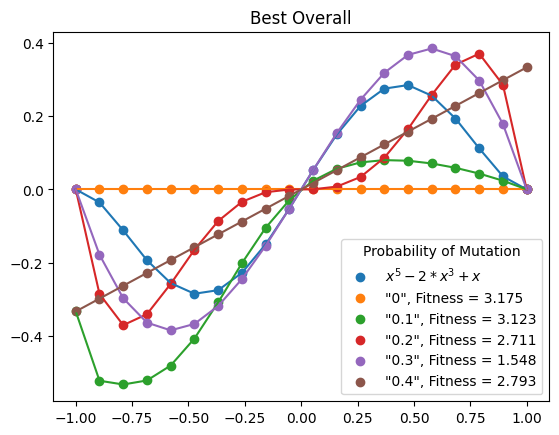

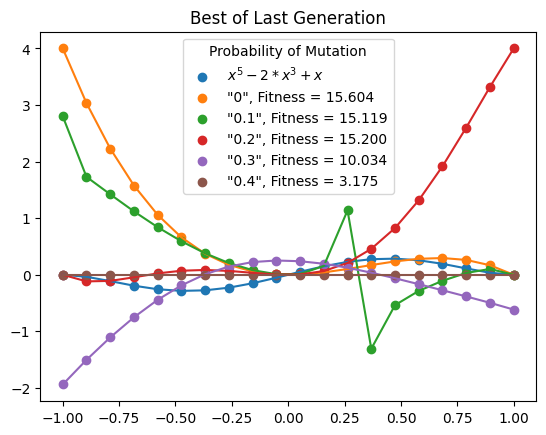

In [ ]:
#@title Probability of Mutation
label_title = 'Probability of Mutation'
key = 'p_m'
labels = values = [0, 0.1, 0.2, 0.3, 0.4]

# Run simulation
all_pops, all_fits = sim(label_title, key, labels, values)

# Reset value
kwargs[key] = 0.3

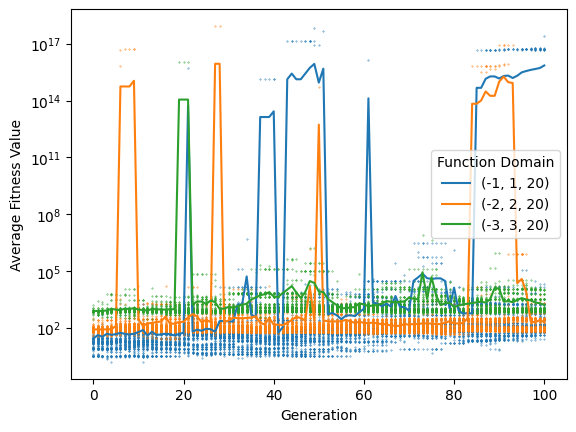

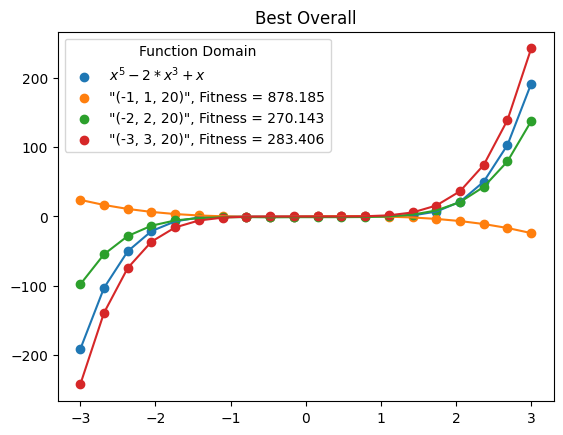

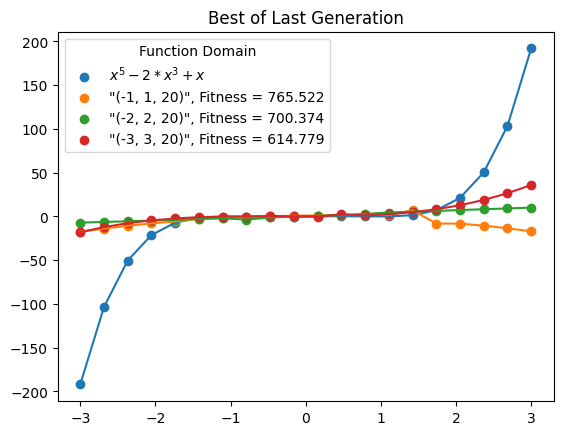

In [ ]:
#@title Function Domain
label_title = 'Function Domain'
key = 'x_linspace'
labels = values = [(-1,1,20), (-2,2,20), (-3,3,20)]

# Run simulation
all_pops, all_fits = sim(label_title, key, labels, values)

# Reset value
kwargs[key] = (-1,1,20)

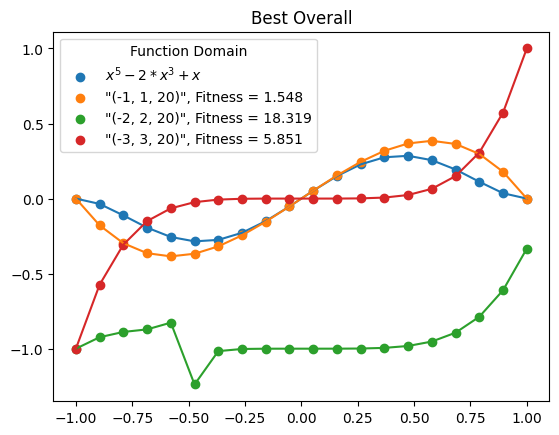

In [ ]:
best(all_pops, all_fits, title='Best Overall', label_title=label_title, labels=labels, **kwargs)

In [ ]:
#@title Algebraic Simplification
label_title = 'Algebraic Simplification'
labels = values = [True, False]
key = 'algebraic'

# Run simulation
all_pops, all_fits = sim(label_title, key, labels, values)

# Report

In general, the genetic algoritm was implemented as follows:


 Process | Implementation
-|-
Representation | Tree
Recombination | Subtree Crossover
Recombination probability | $p_c=0.75$
Mutation | Subtree Mutations
Mutation probability | $p_m=0.3$
Parent selection | Best 1 out of $k=2$ repeated twice (Tournament)
Survival selection | Replace all
Population size | $M=100$
Number of offspring | $2$
Initialisation | Random Tree with max depth $4$ and branch probability $1/2$
Termination condition | Timeout $T_{max}=100$







## A discussion of the chosen parameters and their impact on algorithm behavior.

Nearly all of the parameters were selected through testing or were specified in the requirements. There are a few exceptions and additional parameters were created to test a few extra concepts. One of these is the possible leaf set. While the standard idea is to use $x$ and a few integers and or floats, it is entirely posible to use only $x$. This works exceptionally well for this problem as it speeds the evolution of polynomials will smaller coefficients. Another tested parameter was the domain of the problem. Exponents are difficult to work will between -1 and 1 as the only significant impact is the parity of the exponent. Otherwise, they all have the largest posible value of 1 which means that there is larger than reward when evolving from 0 to $x$ to $x^2$ and so on to $x^5$. However, we can see that by increasing the domain, the algorithm has an easier time finding solutions and the fitness values decreases. The final unique parameter is algebraic simplification. This decreases problems caused by division although it takes so much extra time that it is difficult to justify.

## Presentation of the results, including the best-evolved solutions and their approximation to the target function

We can see the best results of all attempts in comparison to the target function. The best result ever yielded was $-2x^3+x$. The bigest problem likely lies in the fitness function as even with experementing, there was rarely a option that strongly discouraged the evolution of constants or linear equations. This was assisted by further parameter tuning which eventually made such function rarer.


## Visualization of Evolved Programs

The evolution over time of the functions is best described as "cloudy". This is why the graphs show all the individual points as it demonstrates the large amount of variety that is found as solutions evolve. It is also interesting to note that the best results are rarely in the last generation. This is likely due to the agressive impact crossover has on changing solutions. This also indicates that selection is not benifiting as much to the evolution as it should as it is expected that the solutions gradually improve overtime which is not as easy to see through all the noise and bloat, another reason a cloud graph was used.

## Evaluation of algorithm performance, strengths, and limitations.

Overall, the tree model of genetic programming did rather poorly in comparison to what I was anticipating. The graphs over time strongly indicate that solutions were found by chance more so than with proper evolution. Furthermore, the program is slow and difficult to visualize and process. This is also tru with how easily it is for solutions to jump up several orders of magnitude which throws off everything. However, what I find most ineteresting is how well trees can still evolve without and constants. This is something I plan to further investigate as it may be usefull in other problem spaces outside of low coefficient polynomials.